In [1]:
import obonet  # parse obo file
from Bio import SeqIO  # parse fasta file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# file paths
TRAIN_TERMS = "data/Train/train_terms.tsv"
TRAIN_SEQ = "data/Train/train_sequences.fasta"
TRAIN_TAXONOMY = "data/Train/train_taxonomy.tsv"
TEST_SEQ = "data/Test/testsuperset.fasta"
GO_WEIGHTS = "data/IA.tsv"

# Read dataset and create a unified DataFrame

---

In [3]:
# Read data into data frames
train_terms_df = pd.read_csv(TRAIN_TERMS, sep="\t")  # identifier --> label
train_taxonomy_df = pd.read_csv(TRAIN_TAXONOMY, sep="\t", names=['EntryID', 'taxonomyID'])  # identifier --> taxonomy
ia_df = pd.read_csv(GO_WEIGHTS, sep='\t', names=['term', 'ia'])  # GO --> weight

def load_fasta_to_dataframe(file_path, is_train=True):
    records = []
    parser = SeqIO.parse(file_path, "fasta")
    for record in parser:
        entry_id = record.id.split('|')[1] if is_train and '|' in record.id else record.id.split()[0]
        records.append({'EntryID': entry_id, 'sequence': str(record.seq)})
    return pd.DataFrame(records)

train_sequences_df = load_fasta_to_dataframe(TRAIN_SEQ, is_train=True)  # identifier --> input: amino acid sequence


In [4]:
print(train_terms_df[0:2], "\n---")
print(train_taxonomy_df[0:2], "\n---")
print(ia_df[0:2], "\n---")
print(train_sequences_df[0:2], "\n---")

  EntryID        term aspect
0  Q5W0B1  GO:0000785      C
1  Q5W0B1  GO:0004842      F 
---
      EntryID  taxonomyID
0  A0A0C5B5G6        9606
1      A0JNW5        9606 
---
         term        ia
0  GO:0000001  0.000000
1  GO:0000002  2.849666 
---
      EntryID                                           sequence
0  A0A0C5B5G6                                   MRWQEMGYIFYPRKLR
1      A0JNW5  MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL... 
---


In [5]:
# Group the info above into a single data frame
protein_labels = train_terms_df.groupby('EntryID')['term'].apply(list).reset_index(name='labels')  # turn all EntryID duplicates into one EntryID with their terms forming a list
train_df_eda = pd.merge(train_sequences_df, train_taxonomy_df, on='EntryID', how='left')
train_df_eda = pd.merge(train_df_eda, protein_labels, on='EntryID', how='inner')
train_df_eda['seq_length'] = train_df_eda['sequence'].str.len()
train_df_eda['num_labels'] = train_df_eda['labels'].str.len()

In [6]:
print(protein_labels[82399:82401])

      EntryID                    labels
82399  X2JI34  [GO:0106223, GO:0051762]
82400  X4Y2L4  [GO:0033906, GO:0030214]


In [7]:
# Unified data frame
train_df_eda

,EntryID,sequence,taxonomyID,labels,seq_length,num_labels
0,A0A0C5B5G6,MRWQEMGYIFYPRKLR,9606,"[GO:0001649, GO:0033687, GO:0005615, GO:000563...",16,14
1,A0JNW5,MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...,9606,"[GO:0120013, GO:0034498, GO:0005769, GO:012000...",1464,8
2,A0JP26,MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTS...,9606,[GO:0005515],581,1
3,A0PK11,MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDL...,9606,"[GO:0007605, GO:0005515]",232,2
4,A1A4S6,MGLQPLEFSDCYLDSPWFRERIRAHEAELERTNKFIKELIKDGKNL...,9606,"[GO:0005829, GO:0010008, GO:0005515, GO:000509...",786,5
...,...,...,...,...,...,...
82399,Q9UTM1,MSKLKAQSALQKLIESQKNPNANEDGYFRRKRLAKKERPFEPKKLV...,284812,[GO:0005730],112,1
82400,Q9Y7I1,MSSNSNTDHSTGDNRSKSEKQTDLRNALRETESHGMPPLRGPAGFP...,284812,"[GO:0005634, GO:0005829]",78,2
82401,Q9Y7P7,MRSNNSSLVHCCWVSPPSLTRLPAFPSPRILSPCYCYNKRIRPFRG...,284812,"[GO:0005634, GO:0005829]",117,2
82402,Q9Y7Q3,MHSSRRKYNDMWTARLLIRSDQKEEKYPSFKKNAGKAINAHLIPKL...,284812,"[GO:0005634, GO:0005739, GO:0005829]",149,3


# Exploratory Data Analysis (EDA)

---

## EDA0: get basic info of the training DataFrame

In [8]:
print(train_df_eda.info(), "\n---")
print(train_df_eda.describe(), "\n---")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82404 entries, 0 to 82403
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   EntryID     82404 non-null  object
 1   sequence    82404 non-null  object
 2   taxonomyID  82404 non-null  int64 
 3   labels      82404 non-null  object
 4   seq_length  82404 non-null  int64 
 5   num_labels  82404 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 3.8+ MB
None 
---
         taxonomyID    seq_length    num_labels
count  8.240400e+04  82404.000000  82404.000000
mean   8.345517e+04    525.788287      6.517002
std    1.801385e+05    521.574869      7.965655
min    2.870000e+02      3.000000      1.000000
25%    7.955000e+03    250.000000      2.000000
50%    9.913000e+03    409.000000      4.000000
75%    4.468900e+04    630.000000      8.000000
max    3.400809e+06  35213.000000    233.000000 
---


💡 Finding 1: We have `82404` training examples. Each can have up to 233 GOs.

💡 Finding 2: We have 6 columns: EntryID (object), sequence (object), taxonomyID (int64), labels (object), seq_length (int64), and num_labels (int64)

In [9]:
print(train_df_eda.isnull().sum())

EntryID       0
sequence      0
taxonomyID    0
labels        0
seq_length    0
num_labels    0
dtype: int64


💡 Finding 3: Our training set doesn't having missing values

## EDA1: Inspecting each column

In [10]:
# TaxonomyID
print(train_df_eda['taxonomyID'].value_counts(), "\n---")
print("Proportion of top 20 values: ", f"{train_df_eda['taxonomyID'].value_counts().head(20).sum() / train_df_eda['taxonomyID'].value_counts().sum() * 100:.2f}%")

taxonomyID
9606      17162
10090     12508
3702      11863
559292     5520
10116      4909
          ...  
368049        1
372551        1
429560        1
279730        1
51432         1
Name: count, Length: 1381, dtype: int64 
---
Proportion of top 20 values:  91.05%


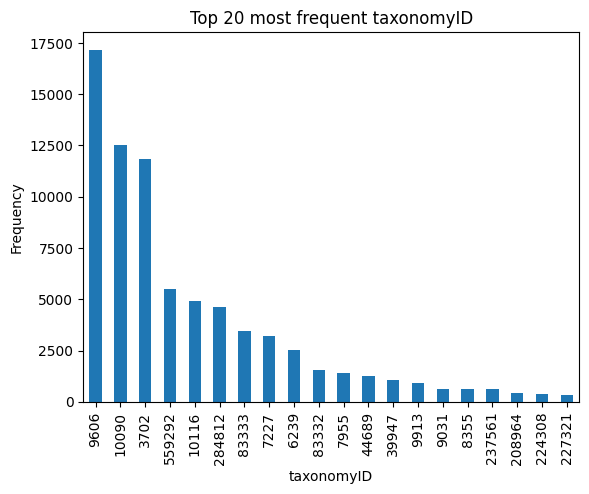

In [11]:
top20_taxonomyID = train_df_eda['taxonomyID'].value_counts().head(20)

top20_taxonomyID.plot(kind='bar')
plt.xlabel("taxonomyID")
plt.ylabel("Frequency")
plt.title("Top 20 most frequent taxonomyID")
plt.show()

💡 Finding 4: There are 1381 unique TaxonomyID values, of which the 20 most frequent values are 91% likely to happen. This means our data largely comprises proteins from very few species (or taxonomies)

In [12]:
# Inspecting seq_length
print(train_df_eda['seq_length'].value_counts(), "\n---")
print("Proportion of top 700 values: ", f"{train_df_eda['seq_length'].value_counts().head(700).sum() / train_df_eda['seq_length'].value_counts().sum() * 100:.2f}%")

# Get top 700 most frequent seq_length values
top_counts = train_df_eda['seq_length'].value_counts().head(700)
# The actual seq_length values
top_values = top_counts.index.values
# Range
print("Range of top 700 values:", top_values.min(), "to", top_values.max())

seq_length
359     187
261     180
309     174
376     172
354     171
       ... 
3413      1
3092      1
3079      1
2688      1
2628      1
Name: count, Length: 2906, dtype: int64 
---
Proportion of top 700 values:  81.25%
Range of top 700 values: 10 to 926


💡 Finding 5: There are 2906 unqiue seq_length values, of which the 700 most frequent values are within [10,926] and are 81% likely to happen. The most frequent sequence length is 359 amino acids. 

In [13]:
# Inspecting aspect
print(train_terms_df['aspect'].value_counts())

aspect
P    250805
C    157770
F    128452
Name: count, dtype: int64


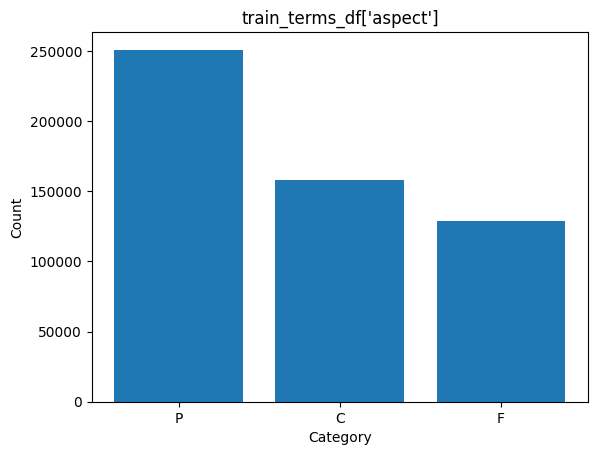

In [14]:
counts_aspect = train_terms_df['aspect'].value_counts()
plt.bar(counts_aspect.index, counts_aspect.values)
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("train_terms_df['aspect']")
plt.show()

💡 Finding 6: Out of the three sub-ontologies, `Biological Process (P)` is the most annotated, then `Cellular Component (C)`, finally `Molecular Function (F)`

In [15]:
# Inspecting labels
unique_terms = list(term for sublist in train_df_eda['labels'] for term in sublist)
print("Number of annotated GO terms:", len(unique_terms))
print("Number of unique GO terms:", len(set(unique_terms)))

Number of annotated GO terms: 537027
Number of unique GO terms: 26125


## EDA2: Finding the correlation between columns

w0 =  5.400144741755019 	w1 =  0.0021241569806198335


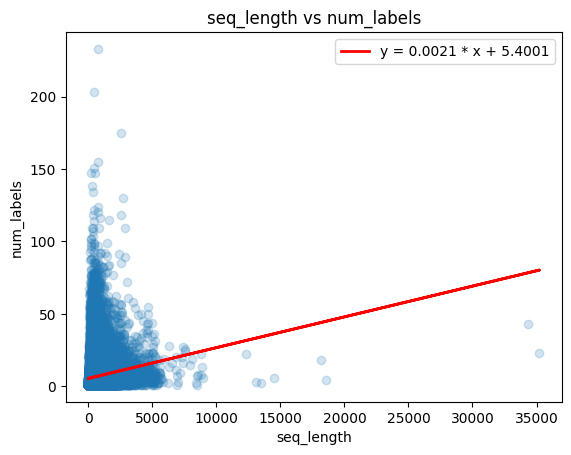

In [16]:
# seq_length and num_labels --> are longer sequences have more GOs?
x = train_df_eda['seq_length']
y = train_df_eda['num_labels']

plt.scatter(x, y, alpha=0.2)
plt.xlabel("seq_length")
plt.ylabel("num_labels")
plt.title("seq_length vs num_labels")

# Fit a simple linear regression
m, b = np.polyfit(x, y, 1)
print("w0 = ", b, "\tw1 = ", m)
plt.plot(x, m*x + b, color='red', linewidth=2, label=f"y = {m:.4f} * x + {b:.4f}")
plt.legend()
plt.show()

In [17]:
print("Correlation score (closer to 1 or -1 means stronger correlation): ", train_df_eda['seq_length'].corr(train_df_eda['num_labels']))  # verify the correlation

Correlation score (closer to 1 or -1 means stronger correlation):  0.13908547272612973


💡 Finding 7: There is a weak positive correlation between `seq_length` and `num_labels`, meaning longer sequences sometimes yield more GOs

In [18]:
# taxonomyID and num_labels --> do certain species have more GOs on average than other IDs?
avg_labels_by_taxon = train_df_eda.groupby('taxonomyID')['num_labels'].mean().sort_values(ascending=False)
print(avg_labels_by_taxon, "\n---")
print(avg_labels_by_taxon.describe())

taxonomyID
2592315    16.0
10144      15.0
409370     13.0
3884       11.0
4673       11.0
           ... 
66546       1.0
167618      1.0
72491       1.0
7225        1.0
36596       1.0
Name: num_labels, Length: 1381, dtype: float64 
---
count    1381.000000
mean        2.791703
std         1.695252
min         1.000000
25%         1.750000
50%         2.500000
75%         3.375000
max        16.000000
Name: num_labels, dtype: float64


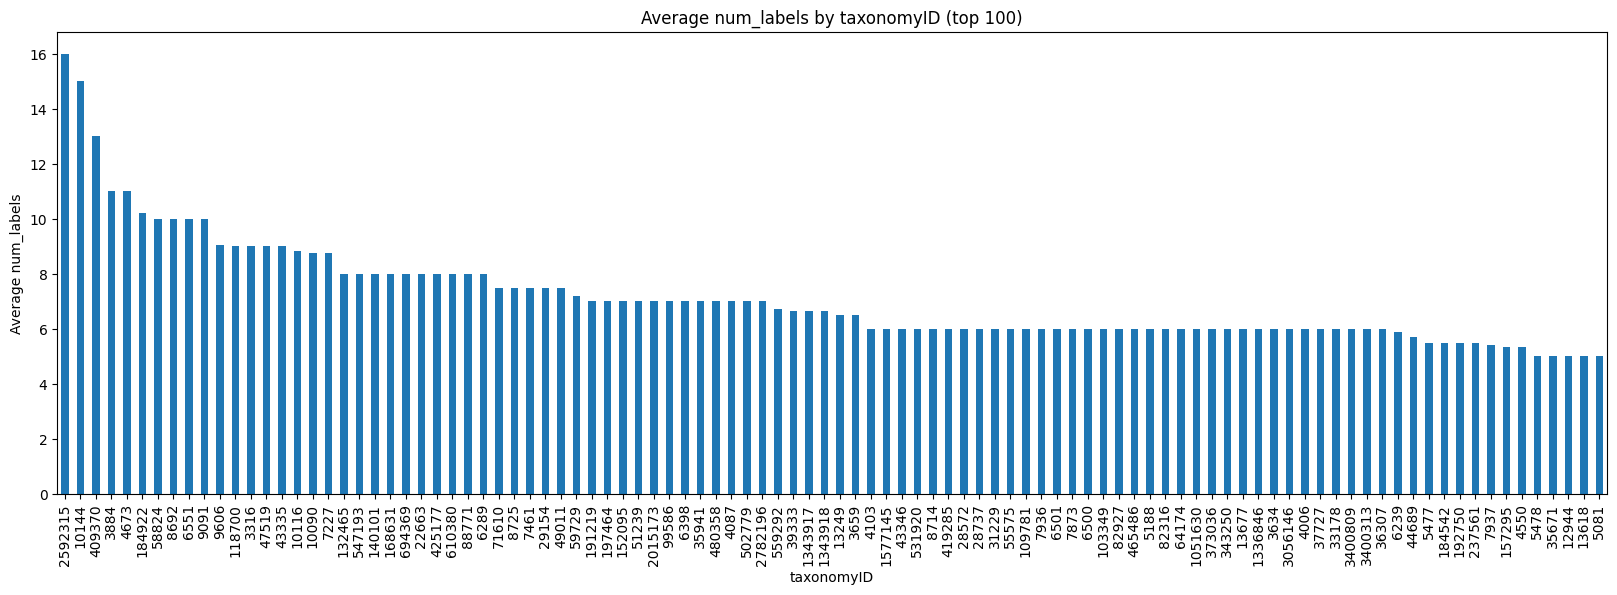

In [19]:
plt.figure(figsize=(20, 6))
top100_taxons_with_highest_labels = avg_labels_by_taxon.head(100)
top100_taxons_with_highest_labels.plot(kind='bar')

plt.xlabel("taxonomyID")
plt.ylabel("Average num_labels")
plt.title("Average num_labels by taxonomyID (top 100)")
plt.show()

In [20]:
# add this info to the dataframe
# train_df_eda['avg_num_labels_by_taxon'] = train_df_eda['taxonomyID'].map(avg_labels_by_taxon)

💡 Finding 8: Some `taxonomyIDs` have more `num_labels` than others (i.e. the mean `num_labels` is `2.791703`, while 25% of the  data has more than 3.375 and up to 16 `num_labels`), validating its usefulness for prediction

---

# EDA - Summary
- `82,404` training examples (each example is a sequence of amino acids of different lengths)
- The `20/1381` most frequent taxonomyIDs (i.e. species) take up `91%` of the dataset 
- The `700/2906` most probable sequence lengths are within `[10,926]` which take up `81%` of the dataset. The most frequent sequence length is `359` characters.
- There is a weak positive correlation between `seq_length` and `num_labels`, meaning longer sequences sometimes yield more GOs
- Some `taxonomyIDs` have more `num_labels` than others (i.e. the mean `num_labels` is `2.791703`, while 25% of the  data has more than 3.375 and up to 16 `num_labels`)
- The annotation:
  - `537,027` annotated GO terms
  - `26,125` unique GO terms
  - Out of the three sub-ontologies, `Biological Process (P)` is the most annotated, then `Cellular Component (C)`, finally `Molecular Function (F)`
- (💡 FYI) A standard protein sequence is made up of 20 amino acid letters, each represented by a single uppercase English letter. 
  - A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y
  - Besides the 20 standard amino acids, protein sequences sometimes include:
    - `B` --> Aspartic acid (D) or Asparagine (N)
    - `Z` --> Glutamic acid (E) or Glutamine (Q)
    - `X` --> Unknown amino acid
    - `J` --> Leucine (L) or Isoleucine (I)
    - `U` --> Selenocysteine
    - `O` --> Pyrrolysine

In [21]:
train_df_eda.head()

,EntryID,sequence,taxonomyID,labels,seq_length,num_labels
0,A0A0C5B5G6,MRWQEMGYIFYPRKLR,9606,"[GO:0001649, GO:0033687, GO:0005615, GO:000563...",16,14
1,A0JNW5,MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...,9606,"[GO:0120013, GO:0034498, GO:0005769, GO:012000...",1464,8
2,A0JP26,MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTS...,9606,[GO:0005515],581,1
3,A0PK11,MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDL...,9606,"[GO:0007605, GO:0005515]",232,2
4,A1A4S6,MGLQPLEFSDCYLDSPWFRERIRAHEAELERTNKFIKELIKDGKNL...,9606,"[GO:0005829, GO:0010008, GO:0005515, GO:000509...",786,5


In [22]:
train_df_eda.to_csv("train.csv", index=False)